# CROP-seq KO150 - DEA within condition between KOs & across conditions within KOs
- input: normalized data
- output: DEGs with log fold change and p-values, volcano plots, summary dot plot

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries

# for Seurat (limma via conda install)
library(dplyr)
library(Seurat) # installed via conda install (conda forge channel)
library(patchwork)
library(ggplot2)
library(DESeq2)
library(cowplot)
library(glmGamPoi) # for faster sctransform

# for gene list converter
library(biomaRt)

# for Upset plots
library(UpSetR)
library(fastDummies)

# for volcano plots
library(EnhancedVolcano)

library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, 

In [4]:
# configs
mixscape_only <- TRUE
# mixscape_only <- FALSE

if (mixscape_only){
    data_path <- file.path('results','KO150','unsupervised_mixscape')
    results_path <- file.path('results','KO150', 'DEA_condition_mixscape')
}else{
    data_path <- file.path('results','KO150')
    results_path <- file.path(data_path, 'DEA_condition')
}

In [5]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE)

# load data

In [5]:
# loading Seurat object
if (mixscape_only){
    KO150 <-readRDS(file = file.path(data_path,paste0("KO150_normalized_Seurat.rds")))
}else{
    KO150 <-readRDS(file = file.path(data_path,paste0("KO150_normalized_Seurat.rds")))
}
KO150

An object of class Seurat 
46518 features across 6187 samples within 5 assays 
Active assay: SCT (14845 features, 3000 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 2 dimensional reductions calculated: pca, umap

## prepare metadata

In [6]:
KO150[['condition']] <- str_split_fixed(KO150$hto_demux, "_", 2)[,2]

In [7]:
KO150$KO_call[KO150$KO_call=='NonTargeting-'] <- 'NonTargeting'

## Violin plots of 2 AB-KO gene pairs as sanity checks

In [8]:
Idents(object = KO150) <- "KO_call"
levels(KO150)

[1] "Smc1a"        "Ifnar1"       "Sfpq"         "Tyk2"         "NonTargeting"
 [6] "Irf9"         "Spi1"         "Ep400"        "Ep300"        "Arid1a"      
[11] "Ikzf1"        "Dnttip2"      "Stat2"        "Chd4"         "Yeats2"      
[16] "Brd2"         "Jak1"         "Dnmt1"        "Med14"        "Sf3b1"       
[21] "Chd8"         "Runx1"        "Smarca4"      "Yeats4"       "Myd88"       
[26] "Stat1"        "Med8"         "Irf3"         "Ddx21"

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.

Saving 6.67 x 6.67 in image



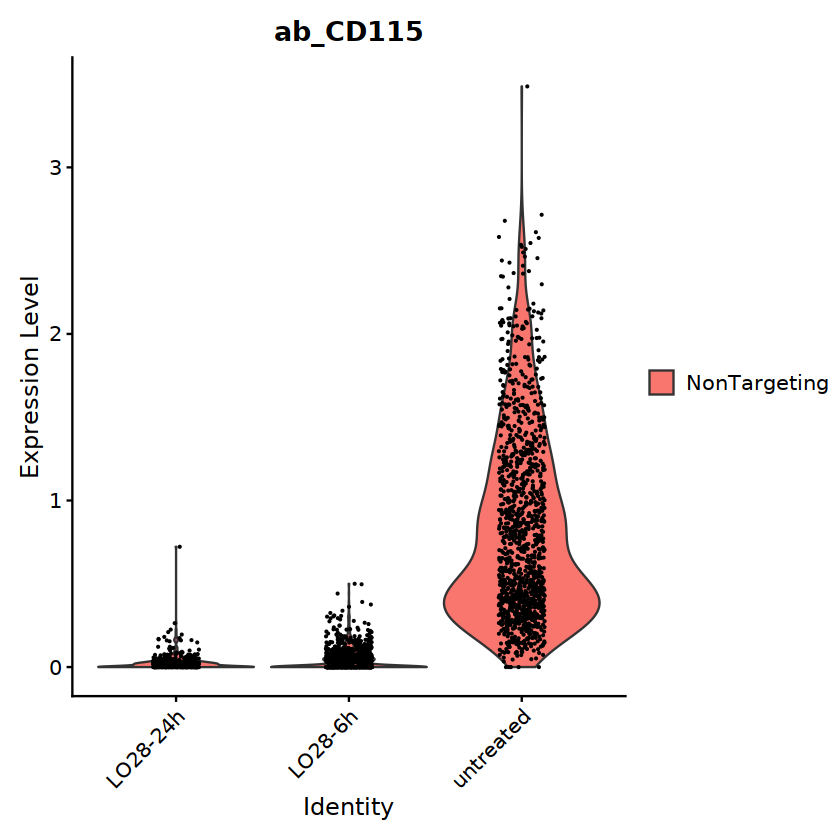

In [9]:
# antibody Csf1r - CD115 by condition
VlnPlot(KO150, features = "ab_CD115", idents=c("NonTargeting", "Csf1r"), split.by="KO_call", group.by = "condition")

ggsave(
  paste0("KO150_",'violin',"_",'AB_CD115_KO_Csf1r_by_condition', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Saving 6.67 x 6.67 in image



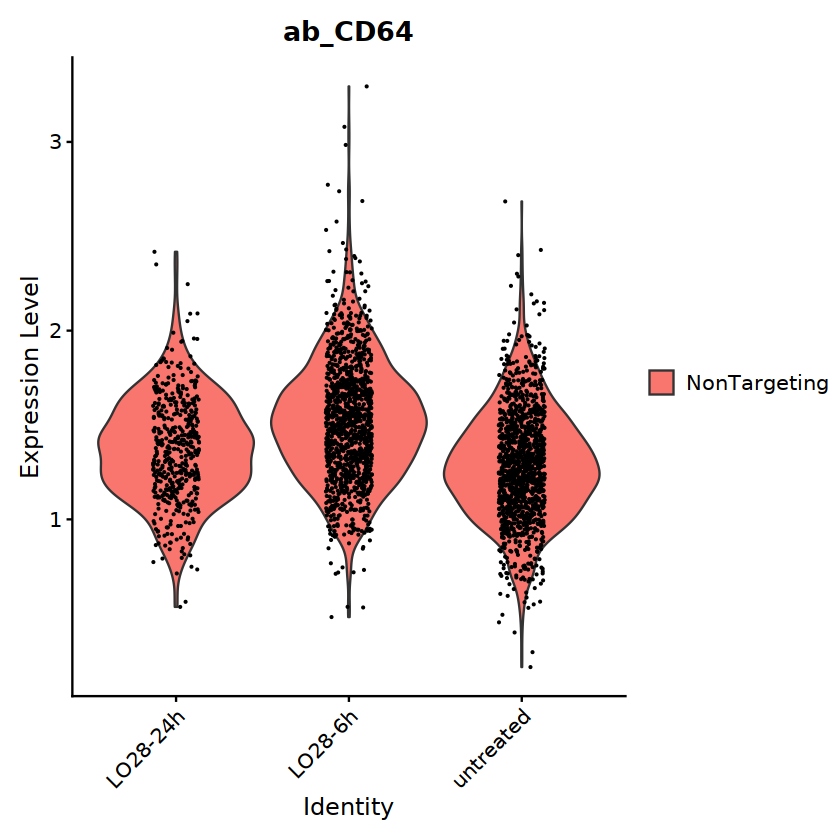

In [10]:
# antibody Fcgr1 - CD64 by condition
VlnPlot(KO150, features = "ab_CD64", idents=c("NonTargeting", "Fcgr1"), split.by="KO_call", group.by = "condition")

ggsave(
  paste0("KO150_",'violin',"_",'AB_CD64_KO_Fcgr1_by_condition', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

## Violin plots of target gene expr split by KO/NT grouped by condition

In [11]:
Idents(object = KO150) <- "KO_call"
levels(KO150)

[1] "Smc1a"        "Ifnar1"       "Sfpq"         "Tyk2"         "NonTargeting"
 [6] "Irf9"         "Spi1"         "Ep400"        "Ep300"        "Arid1a"      
[11] "Ikzf1"        "Dnttip2"      "Stat2"        "Chd4"         "Yeats2"      
[16] "Brd2"         "Jak1"         "Dnmt1"        "Med14"        "Sf3b1"       
[21] "Chd8"         "Runx1"        "Smarca4"      "Yeats4"       "Myd88"       
[26] "Stat1"        "Med8"         "Irf3"         "Ddx21"

In [12]:
length(unique(KO150$KO_call))

[1] 29

In [13]:
# violin plots non-targeting vs KO
for (KO_gene in unique(KO150$KO_call)){

    if (KO_gene=="NonTargeting") {
        next
    }

    VlnPlot(KO150, features = paste0("rna_",KO_gene), idents=c("NonTargeting", KO_gene), split.by="KO_call", group.by = "condition")
    
    ggsave(
      paste0("KO150_",'violin',"_expression_",KO_gene,'KO_by_condition', ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



# DEA analysis within condition between KOs
https://satijalab.org/seurat/reference/findmarkers

In [8]:
KO150[["cond_KO"]] <- paste(KO150$condition,KO150$KO_call,sep="+")

In [9]:
Idents(object = KO150) <- "cond_KO"
levels(KO150)

[1] "untreated+Smc1a"        "untreated+Ifnar1"       "untreated+Sfpq"        
 [4] "untreated+Tyk2"         "untreated+NonTargeting" "untreated+Irf9"        
 [7] "untreated+Spi1"         "untreated+Ep400"        "untreated+Ep300"       
[10] "untreated+Arid1a"       "untreated+Ikzf1"        "untreated+Dnttip2"     
[13] "untreated+Stat2"        "untreated+Chd4"         "untreated+Yeats2"      
[16] "untreated+Brd2"         "untreated+Jak1"         "untreated+Dnmt1"       
[19] "untreated+Med14"        "untreated+Sf3b1"        "untreated+Chd8"        
[22] "untreated+Runx1"        "LO28-6h+Irf9"           "LO28-6h+Smarca4"       
[25] "LO28-6h+NonTargeting"   "LO28-6h+Ep300"          "LO28-6h+Spi1"          
[28] "LO28-6h+Arid1a"         "LO28-6h+Dnmt1"          "LO28-6h+Yeats4"        
[31] "LO28-6h+Ep400"          "LO28-6h+Ikzf1"          "LO28-6h+Myd88"         
[34] "LO28-6h+Brd2"           "LO28-6h+Runx1"          "LO28-6h+Smc1a"         
[37] "LO28-6h+Stat1"          "LO28-6h+Med14"          "LO28-6h+Jak1"          
[40] "LO28-6h+Med8"           "LO28-6h+Dnttip2"        "LO28-6h+Ifnar1"        
[43] "LO28-6h+Yeats2"         "LO28-6h+Stat2"          "LO28-6h+Chd4"          
[46] "LO28-6h+Irf3"           "LO28-6h+Sfpq"           "LO28-6h+Ddx21"         
[49] "LO28-24h+Stat2"         "LO28-24h+Smc1a"         "LO28-24h+NonTargeting" 
[52] "LO28-24h+Spi1"          "LO28-24h+Jak1"          "LO28-24h+Ifnar1"       
[55] "LO28-24h+Chd4"          "LO28-24h+Irf9"          "LO28-24h+Ikzf1"        
[58] "LO28-24h+Myd88"         "LO28-24h+Sfpq"          "LO28-24h+Ep400"        
[61] "LO28-24h+Tyk2"

In [10]:
DefaultAssay(KO150)

[1] "SCT"

In [17]:
for (cond in unique(KO150$condition)){
    
    for (KO_gene in unique(KO150$KO_call)){

        if ((KO_gene=="NonTargeting") | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
        
        KO150.RNAmarkers <- FindMarkers(KO150, 
                                        only.pos = FALSE, 
                                        min.pct = 0.1, 
                                        logfc.threshold = 0.1, 
                                        test.use = "wilcox", 
                                        ident.1=paste(cond,KO_gene,sep='+'), 
                                        ident.2=paste(cond,"NonTargeting",sep='+'), 
                                        random.seed=42
                                       )
        write.csv(KO150.RNAmarkers, 
                  file=file.path(results_path,paste0('KO150_DEA_RNA_',cond,'_',KO_gene,'.csv')), 
                  row.names=TRUE
                 )
        
        KO150.ABmarkers <- FindMarkers(KO150, 
                                       only.pos = FALSE, 
                                       min.pct = 0.1, 
                                       logfc.threshold = 0.1, 
                                       test.use = "wilcox", 
                                       assay = "AB", 
                                       ident.1=paste(cond,KO_gene,sep='+'), 
                                       ident.2=paste(cond,"NonTargeting",sep='+'), 
                                       random.seed=42
                                      )
        write.csv(KO150.ABmarkers, 
                  file=file.path(results_path,paste0('KO150_DEA_AB_',cond,'_',KO_gene,'.csv')), 
                  row.names=TRUE
                 )
    }
}

## Make summary tables of DEA results per condition

### stat. sign. via adj. p-value

In [18]:
# load DEA RNA results per condition, filter for sign. genes (adj.p-value<stat_sign), make table of number of sign. genes, up, down
stat_sign <- 0.05

for (cond in unique(KO150$condition)){
#     print(cond)
    
    tmp_df <- setNames(data.frame(matrix(ncol = 3, nrow = length(unique(KO150$KO_call)))), c("DEGs_n", "up", "down"))
    rownames(tmp_df) <- unique(KO150$KO_call)
    
    for (KO_gene in unique(KO150$KO_call)){
#         print(KO_gene)
        if ((KO_gene=="NonTargeting") | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
    
        tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)

        stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
        up_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']>0)
        down_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']<0)

        tmp_df[KO_gene,] <- c(length(stat_genes),up_genes,down_genes)
    }
#     print(tmp_df)
    write.csv(tmp_df, file=file.path(results_path,paste0('KO150_DEA_RNA_summary_',cond,'.csv')), row.names=TRUE)
}

In [19]:
# load DEA AB results per condition, filter for sign. genes (adj.p-value<stat_sign), make table of number of sign. genes, up, down
stat_sign <- 0.05

for (cond in unique(KO150$condition)){
#     print(cond)
    
    tmp_df <- setNames(data.frame(matrix(ncol = 3, nrow = length(unique(KO150$KO_call)))), c("DEABs_n", "up", "down"))
    rownames(tmp_df) <- unique(KO150$KO_call)
    
    for (KO_gene in unique(KO150$KO_call)){
#         print(KO_gene)
        if ((KO_gene=="NonTargeting") | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
    
        tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_AB_',cond,'_',KO_gene,'.csv')), row.names=1)

        stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
        up_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']>0)
        down_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']<0)

        tmp_df[KO_gene,] <- c(length(stat_genes),up_genes,down_genes)
    }
#     print(tmp_df)
    write.csv(tmp_df, file=file.path(results_path,paste0('KO150_DEA_AB_summary_',cond,'.csv')), row.names=TRUE)
}

### stat. sign. via p-value

In [20]:
# load DEA RNA results per condition, filter for sign. genes (adj.p-value<stat_sign), make table of number of sign. genes, up, down
stat_sign <- 0.05

for (cond in unique(KO150$condition)){
#     print(cond)
    
    tmp_df <- setNames(data.frame(matrix(ncol = 3, nrow = length(unique(KO150$KO_call)))), c("DEGs_n", "up", "down"))
    rownames(tmp_df) <- unique(KO150$KO_call)
    
    for (KO_gene in unique(KO150$KO_call)){
#         print(KO_gene)
        if ((KO_gene=="NonTargeting") | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
    
        tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)

        stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val<stat_sign]
        up_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']>0)
        down_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']<0)

        tmp_df[KO_gene,] <- c(length(stat_genes),up_genes,down_genes)
    }
#     print(tmp_df)
    write.csv(tmp_df, file=file.path(results_path,paste0('KO150_DEA_RNA_summary_',cond,'_pvalue','.csv')), row.names=TRUE)
}

In [21]:
# load DEA AB results per condition, filter for sign. genes (adj.p-value<stat_sign), make table of number of sign. genes, up, down
stat_sign <- 0.05

for (cond in unique(KO150$condition)){
#     print(cond)
    
    tmp_df <- setNames(data.frame(matrix(ncol = 3, nrow = length(unique(KO150$KO_call)))), c("DEABs_n", "up", "down"))
    rownames(tmp_df) <- unique(KO150$KO_call)
    
    for (KO_gene in unique(KO150$KO_call)){
#         print(KO_gene)
        if ((KO_gene=="NonTargeting") | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
    
        tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_AB_',cond,'_',KO_gene,'.csv')), row.names=1)

        stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val<stat_sign]
        up_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']>0)
        down_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']<0)

        tmp_df[KO_gene,] <- c(length(stat_genes),up_genes,down_genes)
    }
#     print(tmp_df)
    write.csv(tmp_df, file=file.path(results_path,paste0('KO150_DEA_AB_summary_',cond,'_pvalue','.csv')), row.names=TRUE)
}

## heatmaps of top DEGs per condition
https://satijalab.org/seurat/reference/doheatmap

In [22]:
# load DEA results per condition, filter for sign. genes (adj.p-value<stat_sign), take union of top_n, make heatmap
top_n <- 1
stat_sign <- 0.05
plot_dims <- 20

for (cond in unique(KO150$condition)){
#     print(cond)
    cond_genes <- vector()
    for (KO_gene in unique(KO150$KO_call)){
#         print(KO_gene)
        if ((KO_gene=="NonTargeting") | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
        tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)
        cond_genes <- append(cond_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign][1:top_n])
    }
    DoHeatmap(KO150, cells=colnames(KO150)[KO150$condition==cond], group.by="KO_call", features = unique(cond_genes),  size = 3, angle=90) + NoLegend()
    ggsave(
      paste0("KO150_",'heatmap',"_DEA_RNA_",cond,"_top",top_n,"union.svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        height = plot_dims,#*length(unique(cond_genes))/length(unique(KO150$KO_call)),
        width = plot_dims
    )
}

Warning message in DoHeatmap(PT149, cells = colnames(PT149)[PT149$condition == cond], :
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: Ccr10, Rps10, Rpl3”
Warning message in DoHeatmap(PT149, cells = colnames(PT149)[PT149$condition == cond], :
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: Rpl10a, Rps10, Rps9, Zcchc24”
Warning message in DoHeatmap(PT149, cells = colnames(PT149)[PT149$condition == cond], :
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: Ptpru”


## clustermap of DEA avgLFCs per condition (DEGs x DEA)

In [12]:
library(pheatmap)
library(ggplotify)

Warning message:
“package ‘pheatmap’ was built under R version 4.0.5”
Warning message:
“package ‘ggplotify’ was built under R version 4.0.5”


In [13]:
stat_sign <- 0.05

[1] 50.90448
[1] 43.06969


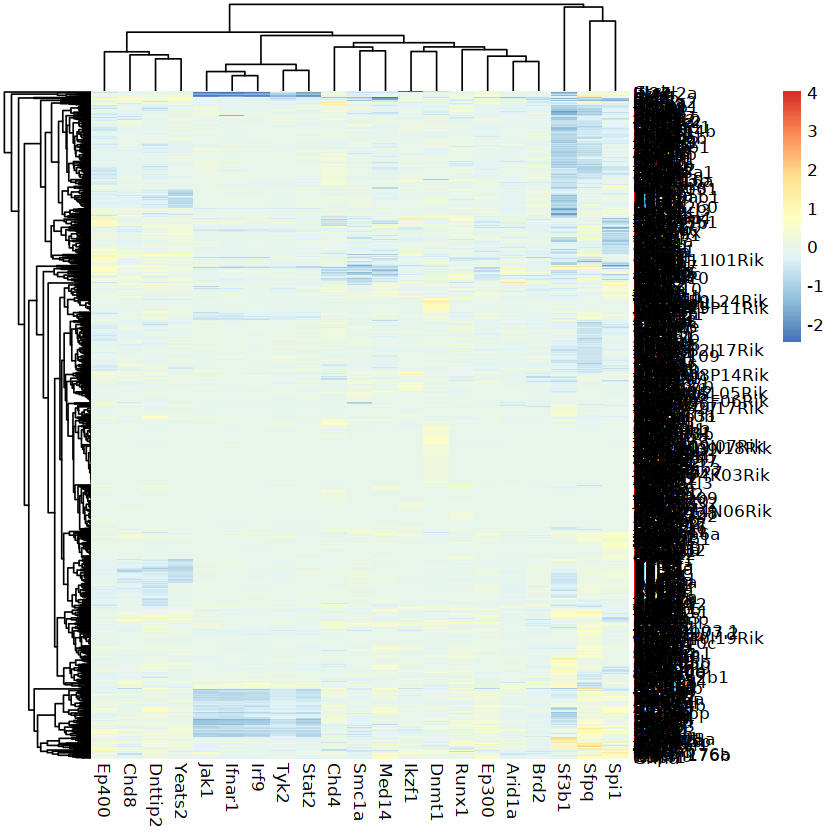

[1] 39.26941


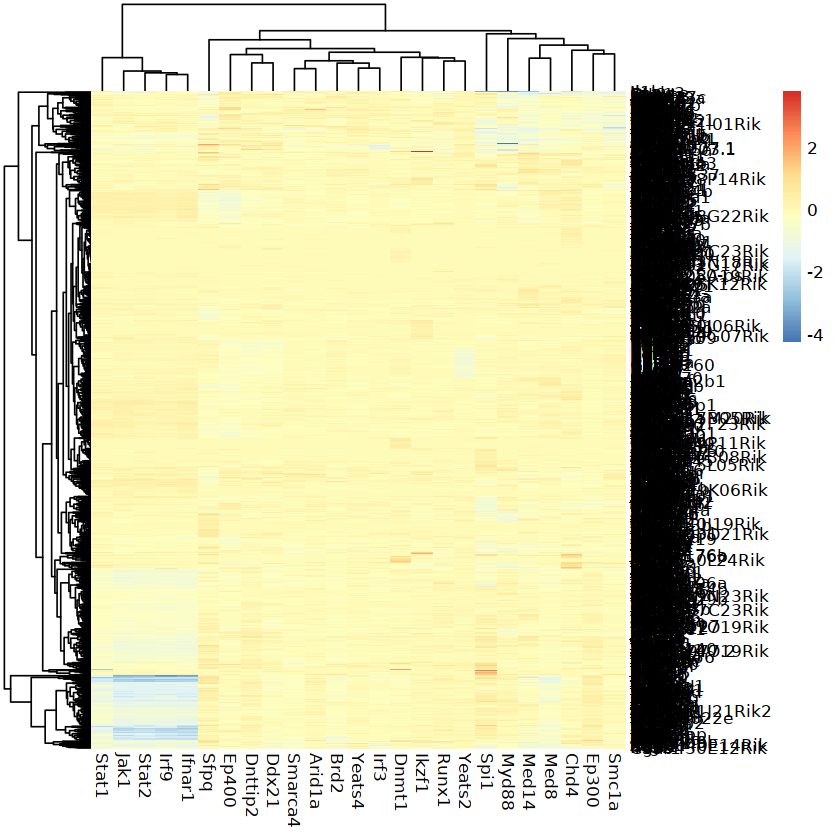

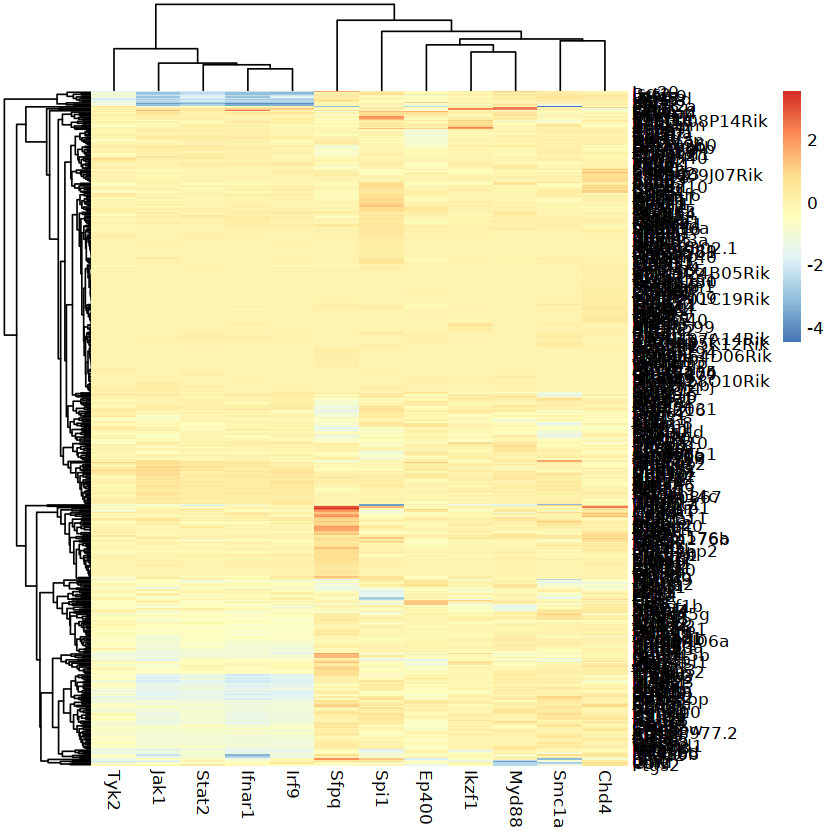

In [14]:
for (cond in unique(KO150$condition)){
    # make list of DEGs across all DEAs in a given condition
    cond_genes <- vector()
    for (KO_gene in unique(KO150$KO_call)){
    #         print(KO_gene)
            if ((KO_gene=="NonTargeting") | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
                next
            }
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)
            cond_genes <- append(cond_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign])
        }

    cond_genes <- unique(cond_genes)
    length(cond_genes)

    # make dataframe consisting of avg_log2FC of the identified DEGs
    DEG_LFC_df = data.frame(matrix(ncol=length(unique(KO150$KO_call[KO150$condition==cond]))-1,nrow=length(cond_genes), dimnames=list(cond_genes, unique(KO150$KO_call[KO150$condition==cond])[unique(KO150$KO_call[KO150$condition==cond])!='NonTargeting'])))

    for (KO_gene in unique(KO150$KO_call)){
    #         print(KO_gene)
        if ((KO_gene=="NonTargeting") | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
        tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)

        DEG_LFC_df[cond_genes,KO_gene] <- tmp_dea_genes[cond_genes,'avg_log2FC']
    }
    head(DEG_LFC_df)
    dim(DEG_LFC_df)

    print(sum(is.na(DEG_LFC_df))/(dim(DEG_LFC_df)[1]*dim(DEG_LFC_df)[2])*100)
    
    #save dataframe
    write.csv(DEG_LFC_df, file=file.path(results_path,paste0('KO150_DEA_RNA_LFC_',cond,'.csv')))
    
    # plot heatmap of LFC

    # impute NA with 0 -> actually just below 0.1
    DEG_LFC_df[is.na(DEG_LFC_df)] <- 0

    width <- 20
    height <- 20

    tmp_plot <- as.ggplot(pheatmap(DEG_LFC_df))

    # save plot
    ggsave(
          paste0("KO150_",'clustermap',"_DEA_RNA_LFC_",cond,'.png'),
          plot = tmp_plot,
          device = 'png',
          path = file.path(results_path),
          scale = 1,
          dpi = 300,
            width = width,
            height = height,
          limitsize = FALSE,
        )
}

## clustermap of DEA AB avgLFCs per condition (DEPs x DEA)

In [11]:
library(pheatmap)
library(ggplotify)
library(tidyr)

Warning message:
“package ‘pheatmap’ was built under R version 4.0.5”
Warning message:
“package ‘ggplotify’ was built under R version 4.0.5”

Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand




In [12]:
stat_sign <- 0.05
width <- 5

In [13]:
# aggregate all DEA AB results
dea_ab_results <- data.frame()
for (cond in unique(KO150$condition)){
    for (KO_gene in unique(KO150$KO_call)){
        
        if ((KO_gene=="NonTargeting")  | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
        
        tmp_dea_res <- read.csv(file=file.path(results_path,paste0('KO150_DEA_AB_',cond,'_',KO_gene,'.csv')), row.names=1)
        if (dim(tmp_dea_res)[1]==0){
            next
        }
        tmp_dea_res$ab <- rownames(tmp_dea_res)
        rownames(tmp_dea_res) <- NULL
        tmp_dea_res$group <- paste0(cond,'_',KO_gene)
        
        if(dim(dea_ab_results)[1]==0){
            dea_ab_results <- tmp_dea_res
        }else{
            dea_ab_results <- rbind(dea_ab_results, tmp_dea_res)
        }
    }
}

dim(dea_ab_results)
head(dea_ab_results)

[1] 313   7

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,ab,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,4.377974e-04,-0.4533645,1,1,4.815772e-03,CD14,untreated_Smc1a
2,3.652182e-02,0.1229961,1,1,4.017400e-01,CD64,untreated_Smc1a
3,9.286823e-02,0.1444304,1,1,1.000000e+00,CD80,untreated_Smc1a
4,6.487529e-01,-0.1382612,1,1,1.000000e+00,CD274,untreated_Smc1a
5,3.973496e-08,-0.2437832,1,1,4.370845e-07,CD64,untreated_Ifnar1
6,2.031514e-04,-0.2022351,1,1,2.234665e-03,CD274,untreated_Ifnar1


In [14]:
# make adjp dataframe for visualization of significance with *
dea_ab_results_adjp <- pivot_wider(dea_ab_results,id_cols='group', names_from='ab',  values_from = "p_val_adj", values_fill = 1)
dea_ab_results_adjp <- data.frame(dea_ab_results_adjp, row.names=dea_ab_results_adjp$group)
dea_ab_results_adjp$group <- NULL
mask <- dea_ab_results_adjp<stat_sign
dea_ab_results_adjp[mask] <- '*'
dea_ab_results_adjp[!mask] <- ' '
# dim(dea_ab_results_adjp)
# head(dea_ab_results_adjp)

In [15]:
# make LFC dataframe for visualization of effect size
dea_ab_results_lfc <- pivot_wider(dea_ab_results,id_cols='group', names_from='ab',  values_from = "avg_log2FC", values_fill = 0)
dea_ab_results_lfc <- data.frame(dea_ab_results_lfc, row.names=dea_ab_results_lfc$group)
dea_ab_results_lfc$group <- NULL
# dim(dea_ab_results_lfc)
# head(dea_ab_results_lfc)

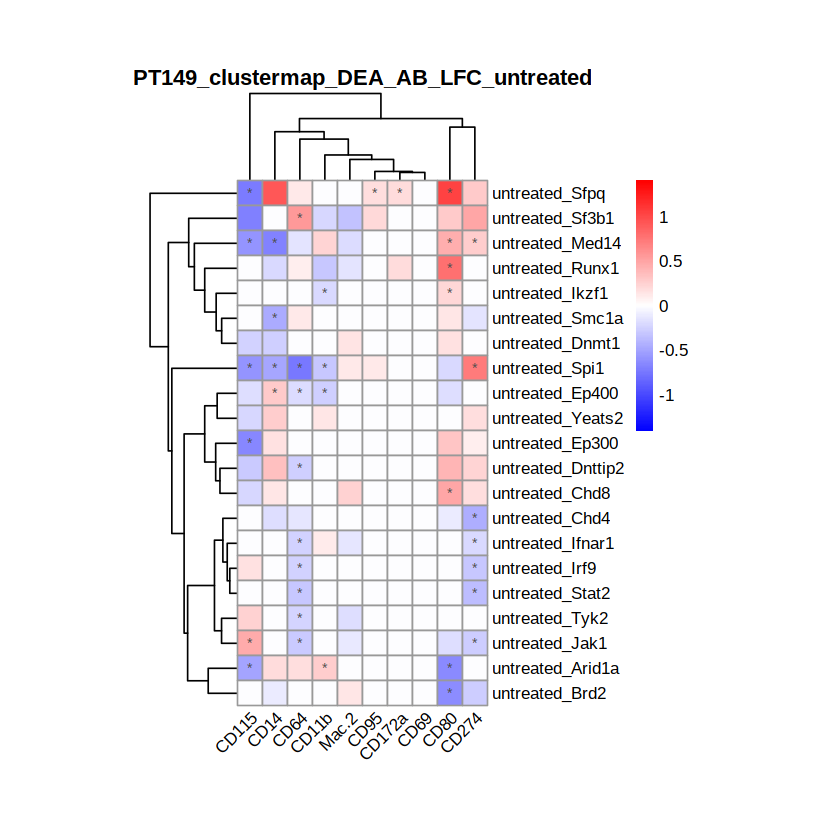

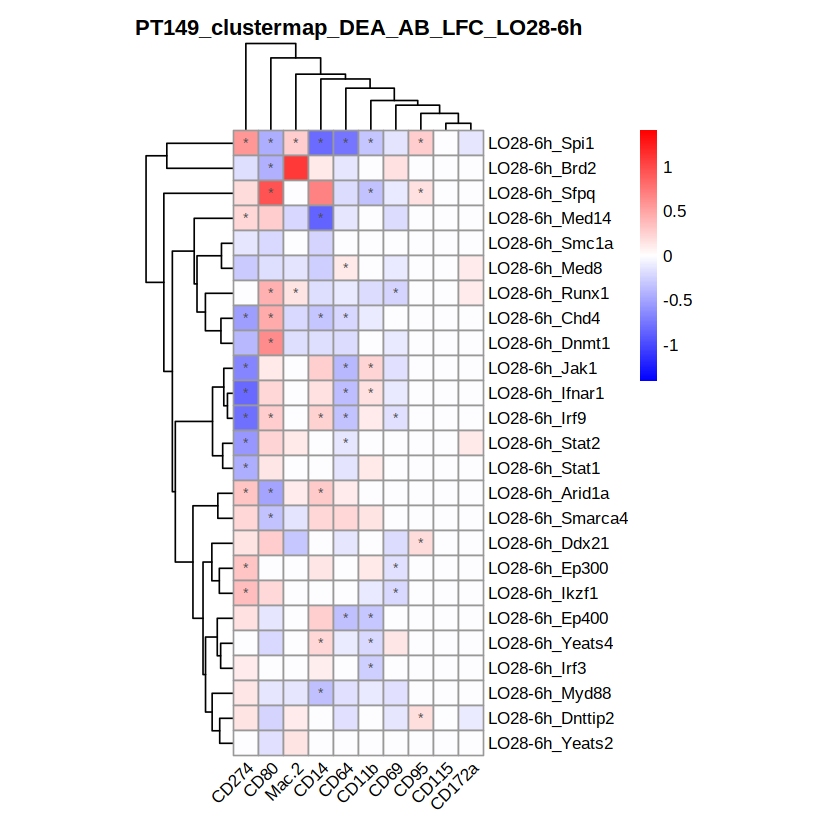

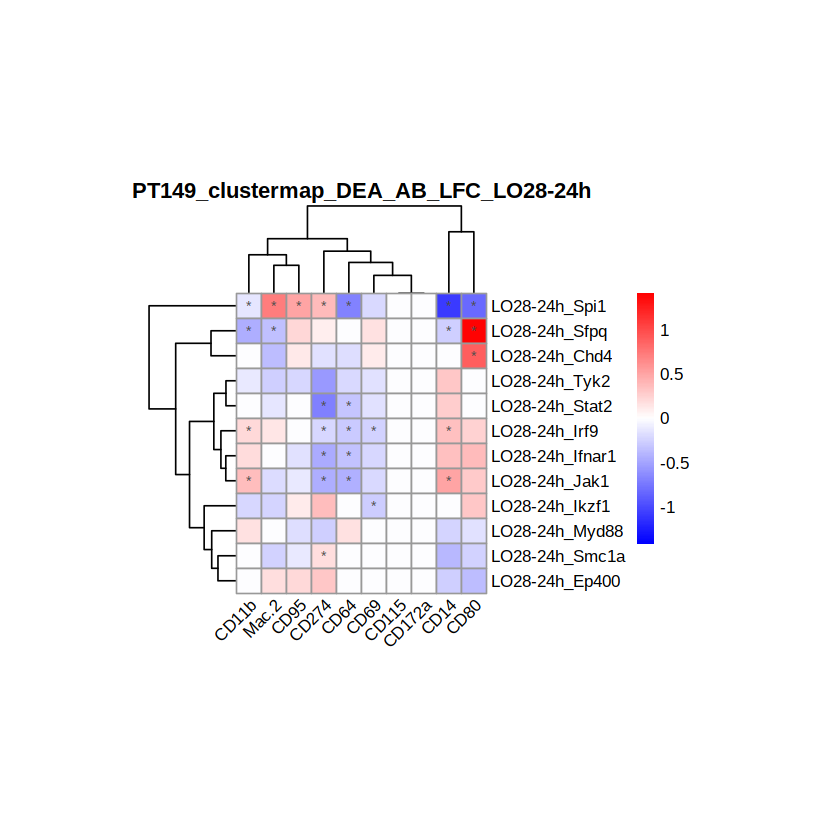

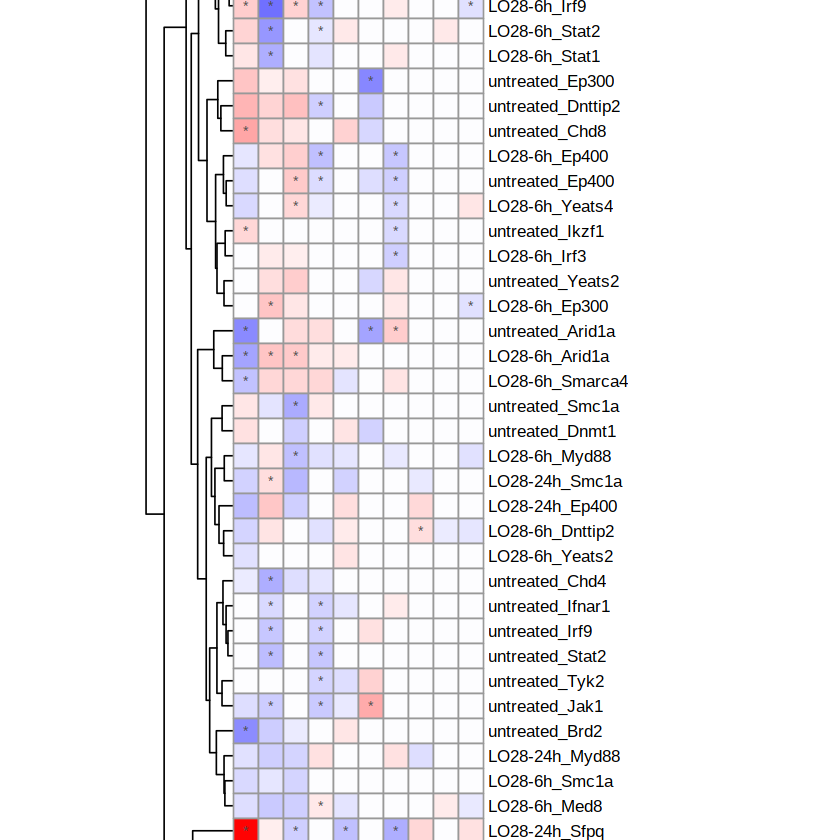

In [19]:
for (cond in c(unique(KO150$condition), 'all')){
    
    # select results
    if (cond=='all'){
        height <- if(mixscape_only) 25 else 100
        tmp_lfc <- dea_ab_results_lfc
        tmp_adjp <- dea_ab_results_adjp
    }else{
        height <- if(mixscape_only) 10 else 30
        tmp_idx <- grepl(cond, rownames(dea_ab_results_lfc), fixed = TRUE)
        tmp_lfc <- dea_ab_results_lfc[tmp_idx,]
        tmp_adjp <- dea_ab_results_adjp[tmp_idx,]
    }
    
    # plot and save heatmap
    tmp_plot <- as.ggplot(pheatmap(tmp_lfc,
             display_numbers=as.matrix(tmp_adjp),
                                   main = paste0("KO150_",'clustermap',"_DEA_AB_LFC_",cond),
             cellwidth = 15,
             cellheight = 15,
             angle_col = "45",
             breaks=seq(-max(abs(dea_ab_results_lfc)), max(abs(dea_ab_results_lfc)), length.out=200),
             color=colorRampPalette(c("blue", "white", "red"))(200)))

    # save plot
    ggsave(
          paste0("KO150_",'clustermap',"_DEA_AB_LFC_",cond,'.png'),
          plot = tmp_plot,
          device = 'png',
          path = file.path(results_path),
          scale = 1,
          dpi = 300,
            width = width,
            height = height,
          limitsize = FALSE,
        )
}

## dotplots of top DEGs per condition
https://satijalab.org/seurat/reference/dotplot

In [26]:
Idents(object = KO150) <- "condition"
levels(KO150)

[1] "untreated" "LO28-6h"   "LO28-24h"

In [27]:
# load DEA results per condition, filter for sign. genes (adj.p-value<stat_sign), take union of top_n, make dotplot
top_n <- 1
stat_sign <- 0.05
plot_dims <- 40

for (cond in unique(KO150$condition)){
#     print(cond)
    cond_genes <- vector()
    for (KO_gene in unique(KO150$KO_call)){
#         print(KO_gene)
        if ((KO_gene=="NonTargeting") | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
        tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)
        cond_genes <- append(cond_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign][1:top_n])
    }
    DotPlot(KO150, idents=c(cond), group.by="KO_call", features = unique(cond_genes))+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    ggsave(
      paste0("KO150_",'dotplot',"_DEA_RNA_",cond,"_top",top_n,"union.svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        height = plot_dims,
        width = plot_dims*length(unique(cond_genes))/length(unique(KO150$KO_call))
    )
}

## Volcano plots for DEA results per condition

In [28]:
DefaultAssay(KO150)

[1] "SCT"

In [29]:
for (cond in unique(KO150$condition)){
#     print(cond)
    
    for (KO_gene in unique(KO150$KO_call)){
#         print(KO_gene)
        if ((KO_gene=="NonTargeting") | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
        
        RNA <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)

        AB <- read.csv(file=file.path(results_path,paste0('KO150_DEA_AB_',cond,'_',KO_gene,'.csv')), row.names=1)

        res <- rbind(RNA, AB)

        keyvals.shape <- ifelse(rownames(res)%in%rownames(AB), 17, 20)# before 17,1
        names(keyvals.shape)[keyvals.shape == 17]<-"AB"
        names(keyvals.shape)[keyvals.shape == 20]<-"RNA"

        EnhancedVolcano(
            res,
            lab = rownames(res),
            x = 'avg_log2FC',
            y = 'p_val_adj',
            title = cond,
            subtitle = paste0(KO_gene,' KO'),
            xlab=expression('average log'[2]*' fold change'),
            ylab=expression('-log'[10]*' adjusted p-value'),
            legendLabels=c('NS','avg.log2FC','adj.p-value', 'both'),
            pCutoff = 0.05,
            FCcutoff = 0.5,
            pointSize = 1.0,
            labSize = 3.0,
            colAlpha = 0.5,
            shapeCustom = keyvals.shape,
            legendPosition = 'right', #top, right, left, none
            caption = bquote("cutoffs avg." ~log[2]~ "FC 0.5; adj.p-value 0.05"),
        )

        ggsave(
          paste0("KO150_",'volcano',"_DEA_",cond,"_",KO_gene,".svg"),
          plot = last_plot(),
          device = "svg",
          path = file.path(results_path),
          scale = 1,
          dpi = 300,
          limitsize = FALSE,
        )
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 

## Enrichment plots for DEA results per condition

In [30]:
# make directories if not exist
dir.create(file.path(results_path, 'enrichment_analysis'), showWarnings = FALSE)

In [31]:
DefaultAssay(KO150)

[1] "SCT"

In [32]:
library(enrichR)

Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is available!

WormEnrichr ... 
Connection is available!

YeastEnrichr ... 
Connection is available!

FishEnrichr ... 
Connection is available!



In [33]:
# parameters for testing
# cond <- 'untreated'
# KO_gene <- 'Yeats2'
# enrich.database <- 'KEGG_2019_Mouse' #'GO_Biological_Process_2021'  'KEGG_2019_Mouse' 'WikiPathways_2019_Mouse'

In [34]:
# parameters for enrichment plots
p_val_metric <- 'p_val_adj' # 'p_val_adj' 'p_val'
p.val.cutoff <- 0.05
num.pathway <- 25
cols <- NULL
balanced <- TRUE

In [35]:
for (enrich.database in c('GO_Biological_Process_2021','KEGG_2019_Mouse','WikiPathways_2019_Mouse')){
    for (cond in unique(KO150$condition)){
    #     print(cond)

        for (KO_gene in unique(KO150$KO_call)){
    #         print(KO_gene)
            if ((KO_gene=="NonTargeting") | (sum(KO150$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
                next
            }
            all.markers <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)

            pos.markers <- all.markers[all.markers[, 2] > 0 & all.markers[, p_val_metric] < p.val.cutoff, , drop = FALSE]
            neg.markers <- all.markers[all.markers[, 2] < 0 & all.markers[, p_val_metric] < p.val.cutoff, , drop = FALSE]

            if(nrow(pos.markers) == 0){
                message("No positive markers pass the logfc.thershold")
              }else{
                pos.markers.list <- rownames(x = pos.markers)[1:nrow(x = pos.markers)]
                pos.er <- enrichR::enrichr(genes = pos.markers.list, databases = enrich.database)
                pos.er <- do.call(what = cbind, args = pos.er)
                pos.er$log10pval <- -log10(x = pos.er[, paste(enrich.database, sep = ".", "P.value")])
                pos.er$term <- pos.er[, paste(enrich.database, sep = ".", "Term")]
                pos.er <- pos.er[1:num.pathway, ]
                pos.er$term <- factor(x = pos.er$term, levels = pos.er$term[order(pos.er$log10pval)])
                gene.list <- list(pos = pos.er)
            }
            if(nrow(neg.markers) == 0){
                message("No positive markers pass the logfc.thershold")
            }else{
                neg.markers.list <- rownames(x = neg.markers)[1:nrow(x = neg.markers)]
                neg.er <- enrichR::enrichr(genes = neg.markers.list, databases = enrich.database)
                neg.er <- do.call(what = cbind, args = neg.er)
                neg.er$log10pval <- -log10(x = neg.er[, paste(enrich.database, sep = ".", "P.value")])
                neg.er$term <- neg.er[, paste(enrich.database, sep = ".", "Term")]
                neg.er <- neg.er[1:num.pathway, ]
                neg.er$term <- factor(x = neg.er$term, levels = neg.er$term[order(neg.er$log10pval)])
            }

            if(isTRUE(length(neg.er$term) == 0) & isTRUE(length(pos.er == 0))){
                stop("No positive or negative marker genes identified")
                next
            }else{
                if(isTRUE(length(neg.er$term) == 0)){

                    gene.list <- list(pos = pos.er)

                }
                else{
                  gene.list <- list(pos = pos.er, neg = neg.er)
                }
            }

              if(nrow(pos.markers) == 0){
                message("No positive markers to plot")

                if (isTRUE(x = balanced)) {

                  p2 <- ggplot(data = neg.er, aes_string(x = "term", y = "log10pval")) +
                    geom_bar(stat = "identity", fill = "indianred2") +
                    coord_flip() + xlab("Pathway") +
                    scale_fill_manual(values = cols, drop = FALSE) +
                    ylab(paste0("-log10(",p_val_metric,")")) +
                    ggtitle(paste(enrich.database, KO_gene, sep = "_", "negative markers")) +
                    theme_classic() +
                    geom_text(aes_string(label = "term", y = 0),
                              size = 3,
                              color = "black",
                              position = position_dodge(1),
                              hjust = 0)+
                    theme(axis.title.y= element_blank(),
                          axis.text.y = element_blank(),
                          axis.ticks.y = element_blank())
                  p <- p2

                }else{
                    stop("Nothing to plot")
                    next
                }
              }else {
              p <- ggplot(data = pos.er, aes_string(x = "term", y = "log10pval")) +
                geom_bar(stat = "identity", fill = "dodgerblue") +
                coord_flip() + xlab("Pathway") +
                scale_fill_manual(values = cols, drop = FALSE) +
                ylab(paste0("-log10(",p_val_metric,")")) +
                ggtitle(paste(enrich.database, KO_gene, sep = "\n", "positive markers")) +
                theme_classic() +
                geom_text(aes_string(label = "term", y = 0),
                          size = 3,
                          color = "black",
                          position = position_dodge(1),
                          hjust = 0)+
                theme(axis.title.y= element_blank(),
                      axis.text.y = element_blank(),
                      axis.ticks.y = element_blank())
              if (isTRUE(x = balanced)) {

                p2 <- ggplot(data = neg.er, aes_string(x = "term", y = "log10pval")) +
                  geom_bar(stat = "identity", fill = "indianred2") +
                  coord_flip() + xlab("Pathway") +
                  scale_fill_manual(values = cols, drop = FALSE) +
                  ylab(paste0("-log10(",p_val_metric,")")) +
                  ggtitle(paste(enrich.database, KO_gene, sep = "\n", "negative markers")) +
                  theme_classic() +
                  geom_text(aes_string(label = "term", y = 0),
                            size = 3,
                            color = "black",
                            position = position_dodge(1),
                            hjust = 0)+
                  theme(axis.title.y= element_blank(),
                        axis.text.y = element_blank(),
                        axis.ticks.y = element_blank())
                p <- p+p2

              }
              }

            ggsave(
              paste0("KO150_",'enrichment',"_DEA_",cond,"_",KO_gene,"_",enrich.database,".svg"),
              plot = p,
              device = "svg",
              path = file.path(results_path, 'enrichment_analysis'),
              scale = 1,
              dpi = 300,
              limitsize = FALSE,
            )
        }
    }
}

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 1 rows containing missing values (position_stack).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 9 rows containing missing values (position_stack).”
Warning message:
“Removed 9 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


No positive markers pass the logfc.thershold

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 11 rows containing missing values (position_stack).”
Warning message:
“Removed 11 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


No positive markers pass the logfc.thershold

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 11 rows containing missing values (position_stack).”
Warning message:
“Removed 11 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 11 rows containing missing values (position_stack).”
Warning message:
“Removed 11 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 18 rows containing missing values (position_stack).”
Warning message:
“Removed 18 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 11 rows containing missing values (position_stack).”
Warning message:
“Removed 11 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”
Warning message:
“Removed 17 rows containing missing values (position_stack).”
Warning message:
“Removed 17 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”
Warning message:
“Removed 7 rows containing missing values (position_stack).”
Warning message:
“Removed 7 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 16 rows containing missing values (position_stack).”
Warning message:
“Removed 16 rows containing missing values (geom_text).”
Warning message:
“Removed 13 rows containing missing values (position_stack).”
Warning message:
“Removed 13 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 18 rows containing missing values (position_stack).”
Warning message:
“Removed 18 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 17 rows containing missing values (position_stack).”
Warning message:
“Removed 17 rows containing missing values (geom_text).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


No positive markers pass the logfc.thershold

Saving 6.67 x 6.67 in image

Warning message:
“Removed 2 rows containing missing values (position_stack).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 8 rows containing missing values (position_stack).”
Warning message:
“Removed 8 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 13 rows containing missing values (position_stack).”
Warning message:
“Removed 13 rows containing missing values (geom_text).”
Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 5 rows containing missing values (position_stack).”
Warning message:
“Removed 5 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 1 rows containing missing values (position_stack).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 11 rows containing missing values (position_stack).”
Warning message:
“Removed 11 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image

Warning message:
“Removed 6 rows containing missing values (position_stack).”
Warning message:
“Removed 6 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


No positive markers pass the logfc.thershold

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 18 rows containing missing values (position_stack).”
Warning message:
“Removed 18 rows containing missing values (geom_text).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 3 rows containing missing values (position_stack).”
Warning message:
“Removed 3 rows containing missing values (geom_text).”
Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 8 rows containing missing values (position_stack).”
Warning message:
“Removed 8 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”
Warning message:
“Removed 17 rows containing missing values (position_stack).”
Warning message:
“Removed 17 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”
Warning message:
“Removed 18 rows containing missing values (position_stack).”
Warning message:
“Removed 18 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 18 rows containing missing values (position_stack).”
Warning message:
“Removed 18 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 5 rows containing missing values (position_stack).”
Warning message:
“Removed 5 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image

Warning message:
“Removed 18 rows containing missing values (position_stack).”
Warning message:
“Removed 18 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 14 rows containing missing values (position_stack).”
Warning message:
“Removed 14 rows containing missing values (geom_text).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 11 rows containing missing values (position_stack).”
Warning message:
“Removed 11 rows containing missing values (geom_text).”
Warning message:
“Removed 3 rows containing missing values (position_stack).”
Warning message:
“Removed 3 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”
Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 13 rows containing missing values (position_stack).”
Warning message:
“Removed 13 rows containing missing values (geom_text).”
Warning message:
“Removed 9 rows containing missing values (position_stack).”
Warning message:
“Removed 9 rows containing missing values (geom_text).”
No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image

Warning message:
“Removed 13 rows containing missing values (position_stack).”
Warning message:
“Removed 13 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 9 rows containing missing values (position_stack).”
Warning message:
“Removed 9 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”
Warning message:
“Removed 12 rows containing missing values (position_stack).”
Warning message:
“Removed 12 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 16 rows containing missing values (position_stack).”
Warning message:
“Removed 16 rows containing missing values (geom_text).”
Warning message:
“Removed 18 rows containing missing values (position_stack).”
Warning message:
“Removed 18 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 17 rows containing missing values (position_stack).”
Warning message:
“Removed 17 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 2 rows containing missing values (position_stack).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 8 rows containing missing values (position_stack).”
Warning message:
“Removed 8 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”
Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


No positive markers pass the logfc.thershold

Saving 6.67 x 6.67 in image

Warning message:
“Removed 12 rows containing missing values (position_stack).”
Warning message:
“Removed 12 rows containing missing values (geom_text).”
Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 17 rows containing missing values (position_stack).”
Warning message:
“Removed 17 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 13 rows containing missing values (position_stack).”
Warning message:
“Removed 13 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (position_stack).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 17 rows containing missing values (position_stack).”
Warning message:
“Removed 17 rows containing missing values (geom_text).”
Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 8 rows containing missing values (position_stack).”
Warning message:
“Removed 8 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”
Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 5 rows containing missing values (position_stack).”
Warning message:
“Removed 5 rows containing missing values (geom_text).”
No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image

Warning message:
“Removed 12 rows containing missing values (position_stack).”
Warning message:
“Removed 12 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 3 rows containing missing values (position_stack).”
Warning message:
“Removed 3 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


No positive markers pass the logfc.thershold

Saving 6.67 x 6.67 in image

Warning message:
“Removed 4 rows containing missing values (position_stack).”
Warning message:
“Removed 4 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 13 rows containing missing values (position_stack).”
Warning message:
“Removed 13 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 18 rows containing missing values (position_stack).”
Warning message:
“Removed 18 rows containing missing values (geom_text).”
Warning message:
“Removed 17 rows containing missing values (position_stack).”
Warning message:
“Removed 17 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 13 rows containing missing values (position_stack).”
Warning message:
“Removed 13 rows containing missing values (geom_text).”
Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 14 rows containing missing values (position_stack).”
Warning message:
“Removed 14 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 7 rows containing missing values (position_stack).”
Warning message:
“Removed 7 rows containing missing values (geom_text).”
No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image

Warning message:
“Removed 12 rows containing missing values (position_stack).”
Warning message:
“Removed 12 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”
Warning message:
“Removed 16 rows containing missing values (position_stack).”
Warning message:
“Removed 16 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_text).”
Warning message:
“Removed 2 rows containing missing values (position_stack).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 18 rows containing missing values (position_stack).”
Warning message:
“Removed 18 rows containing missing values (geom_text).”
Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 12 rows containing missing values (position_stack).”
Warning message:
“Removed 12 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”
Warning message:
“Removed 7 rows containing missing values (position_stack).”
Warning message:
“Removed 7 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 17 rows containing missing values (position_stack).”
Warning message:
“Removed 17 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 8 rows containing missing values (position_stack).”
Warning message:
“Removed 8 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 4 rows containing missing values (position_stack).”
Warning message:
“Removed 4 rows containing missing values (geom_text).”
Warning message:
“Removed 5 rows containing missing values (position_stack).”
Warning message:
“Removed 5 rows containing missing values (geom_text).”


# DEA analysis within KOs between conditions
https://satijalab.org/seurat/reference/findmarkers

In [15]:
# make directories if not exist
if (mixscape_only){
    results_path <- file.path('results','KO150', 'DEA_KO_mixscape')
}else{
    results_path <- file.path(data_path, 'DEA_KO')
}

dir.create(file.path(results_path), showWarnings = FALSE)

In [16]:
KO150[["cond_KO"]] <- paste(KO150$condition,KO150$KO_call,sep="+")

In [17]:
Idents(object = KO150) <- "cond_KO"
levels(KO150)

[1] "untreated+Smc1a"        "untreated+Ifnar1"       "untreated+Sfpq"        
 [4] "untreated+Tyk2"         "untreated+NonTargeting" "untreated+Irf9"        
 [7] "untreated+Spi1"         "untreated+Ep400"        "untreated+Ep300"       
[10] "untreated+Arid1a"       "untreated+Ikzf1"        "untreated+Dnttip2"     
[13] "untreated+Stat2"        "untreated+Chd4"         "untreated+Yeats2"      
[16] "untreated+Brd2"         "untreated+Jak1"         "untreated+Dnmt1"       
[19] "untreated+Med14"        "untreated+Sf3b1"        "untreated+Chd8"        
[22] "untreated+Runx1"        "LO28-6h+Irf9"           "LO28-6h+Smarca4"       
[25] "LO28-6h+NonTargeting"   "LO28-6h+Ep300"          "LO28-6h+Spi1"          
[28] "LO28-6h+Arid1a"         "LO28-6h+Dnmt1"          "LO28-6h+Yeats4"        
[31] "LO28-6h+Ep400"          "LO28-6h+Ikzf1"          "LO28-6h+Myd88"         
[34] "LO28-6h+Brd2"           "LO28-6h+Runx1"          "LO28-6h+Smc1a"         
[37] "LO28-6h+Stat1"          "LO28-6h+Med14"          "LO28-6h+Jak1"          
[40] "LO28-6h+Med8"           "LO28-6h+Dnttip2"        "LO28-6h+Ifnar1"        
[43] "LO28-6h+Yeats2"         "LO28-6h+Stat2"          "LO28-6h+Chd4"          
[46] "LO28-6h+Irf3"           "LO28-6h+Sfpq"           "LO28-6h+Ddx21"         
[49] "LO28-24h+Stat2"         "LO28-24h+Smc1a"         "LO28-24h+NonTargeting" 
[52] "LO28-24h+Spi1"          "LO28-24h+Jak1"          "LO28-24h+Ifnar1"       
[55] "LO28-24h+Chd4"          "LO28-24h+Irf9"          "LO28-24h+Ikzf1"        
[58] "LO28-24h+Myd88"         "LO28-24h+Sfpq"          "LO28-24h+Ep400"        
[61] "LO28-24h+Tyk2"

In [18]:
DefaultAssay(KO150)

[1] "SCT"

In [19]:
# manually reorder for correct DEA order (newer vs older)
conditions <- unique(KO150$condition)
conditions

[1] "untreated" "LO28-6h"   "LO28-24h"

In [50]:
for (KO_gene in unique(KO150$KO_call)){
#     print(KO_gene)
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
            print(paste(cond1,cond2))
            
            if ((sum(KO150$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO150$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            
            # RNA
            KO150.RNAmarkers <- FindMarkers(KO150, 
                                            only.pos = FALSE, 
                                            min.pct = 0.1, 
                                            logfc.threshold = 0.1, 
                                            test.use = "wilcox", 
                                            ident.1=paste(cond2,KO_gene,sep='+'), 
                                            ident.2=paste(cond1,KO_gene,sep='+'), 
                                            random.seed=42)
            write.csv(KO150.RNAmarkers, file=file.path(results_path,paste0('KO150_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=TRUE)

            # AB
            KO150.ABmarkers <- FindMarkers(KO150, 
                                           only.pos = FALSE, 
                                           min.pct = 0.1, 
                                           logfc.threshold = 0.1, 
                                           test.use = "wilcox",
                                           assay = "AB", 
                                           ident.1=paste(cond2,KO_gene,sep='+'), 
                                           ident.2=paste(cond1,KO_gene,sep='+'), 
                                           random.seed=42)
            write.csv(KO150.ABmarkers, file=file.path(results_path,paste0('KO150_DEA_AB_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=TRUE)
        }
    }
}

[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO28-24h"
[1] "untreated LO28-6h"
[1] "untreated LO28-24h"
[1] "LO28-6h LO

## summary tables of DEA within KO between condition results

In [51]:
conditions <- unique(KO150$condition)
conditions

[1] "untreated" "LO28-6h"   "LO28-24h"

In [52]:
# load all DEA RNA results per KO, filter for sign. genes (adj.p-value<stat_sign), make table of number of sign. genes, up, down
stat_sign <- 0.05

for (KO_gene in unique(KO150$KO_call)){
#     print(KO_gene)
    
    tmp_df <- setNames(data.frame(matrix(ncol = 3, nrow =0)), c("DEGs_n", "up", "down"))
    
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            
            if ((sum(KO150$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO150$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)

            stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
            up_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']>0)
            down_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']<0)

            tmp_df[paste0(cond2,'_VS_',cond1),] <- c(length(stat_genes),up_genes,down_genes)
        }
    }
#     print(tmp_df)
    write.csv(tmp_df, file=file.path(results_path,paste0('KO150_DEA_RNA_summary_',KO_gene,'.csv')), row.names=TRUE)
}

In [53]:
# load all DEA AB results per KO, filter for sign. genes (adj.p-value<stat_sign), make table of number of sign. genes, up, down
stat_sign <- 0.05

for (KO_gene in unique(KO150$KO_call)){
#     print(KO_gene)
    
    tmp_df <- setNames(data.frame(matrix(ncol = 3, nrow =0)), c("DEABs_n", "up", "down"))
    
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            
            if ((sum(KO150$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO150$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_AB_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)

            stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
            up_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']>0)
            down_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']<0)

            tmp_df[paste0(cond2,'_VS_',cond1),] <- c(length(stat_genes),up_genes,down_genes)
        }
    }
#     print(tmp_df)
    write.csv(tmp_df, file=file.path(results_path,paste0('KO150_DEA_AB_summary_',KO_gene,'.csv')), row.names=TRUE)
}

## heatmaps of top DEGs per KO
https://satijalab.org/seurat/reference/doheatmap

In [54]:
# load DEA results per KO gene, filter for sign. genes (adj.p-value<stat_sign), take union of top_n, make heatmap
top_n <- 10
stat_sign <- 0.05
plot_dims <- 10

for (KO_gene in unique(KO150$KO_call)){
#     print(KO_gene)
    KO_genes <- vector()
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            if ((sum(KO150$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO150$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)
            KO_genes <- append(KO_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign][1:top_n])
        }
    }
    
    if (length(unique(KO_genes))==0){
        next
    }
    if (is.na(unique(KO_genes))){
        next
    }
    
    DoHeatmap(KO150, cells=colnames(KO150)[KO150$KO_call==KO_gene], group.by="condition", features = unique(KO_genes),  size = 3, angle=90) + NoLegend()
    
    ggsave(
      paste0("KO150_",'heatmap',"_DEA_RNA_",KO_gene,"_top",top_n,"union.svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        height = plot_dims,#*length(unique(cond_genes))/length(unique(KO150$KO_call)),
        width = plot_dims
    )
}

Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in DoHeatmap(PT149, cells = colnames(PT149)[PT149$KO_call == KO_gene], :
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: Fus”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has le

## clustermap of DEA avgLFCs per condition (DEGs x DEA)

In [20]:
library(pheatmap)
library(ggplotify)

In [21]:
stat_sign <- 0.05

[1] 6482

,Smc1a_LO28-6h_untreated,Smc1a_LO28-24h_untreated,Smc1a_LO28-24h_LO28-6h,Ifnar1_LO28-6h_untreated,Ifnar1_LO28-24h_untreated,Ifnar1_LO28-24h_LO28-6h,Sfpq_LO28-6h_untreated,Sfpq_LO28-24h_untreated,Sfpq_LO28-24h_LO28-6h,Tyk2_LO28-24h_untreated,⋯,Chd4_LO28-24h_LO28-6h,Yeats2_LO28-6h_untreated,Brd2_LO28-6h_untreated,Jak1_LO28-6h_untreated,Jak1_LO28-24h_untreated,Jak1_LO28-24h_LO28-6h,Dnmt1_LO28-6h_untreated,Med14_LO28-6h_untreated,Runx1_LO28-6h_untreated,Myd88_LO28-24h_LO28-6h
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ifit1,3.597909,2.569856,-1.0280535,1.847939,0.1215042,-1.726435,3.581811,1.1555881,-2.4262232,1.989220,⋯,-0.9768308,3.265777,3.582456,1.855131,0.8968165,-0.9583141,3.365723,3.486500,4.199547,-1.2936156
Cmpk2,4.669213,1.533330,-3.1358834,2.099244,-0.3831988,-2.482443,4.319155,1.6434917,-2.6756638,1.103881,⋯,-2.0724085,4.277999,4.338338,2.226877,0.3577711,-1.8691059,4.287431,3.041769,5.117923,-3.0420085
Rsad2,5.100542,4.154818,-0.9457243,2.795284,0.4300134,-2.365271,4.049260,2.7150783,-1.3341819,3.107241,⋯,-1.0900890,4.179934,4.786246,3.353485,1.8147044,-1.5387804,5.270549,4.431520,5.591514,-2.5409040
Slfn2,2.302434,1.875118,-0.4273158,1.864836,0.3392107,-1.525626,1.504821,0.7552328,-0.7495883,1.101679,⋯,-0.8261832,2.017092,2.089191,1.810474,0.8010959,-1.0093783,1.927649,1.556948,2.025129,-0.1879162
Ifit2,3.316162,2.120377,-1.1957848,1.359453,0.1845940,-1.174859,2.781074,1.0463841,-1.7346900,2.297847,⋯,-0.8177967,2.660278,3.042380,1.397772,1.3366080,NA,2.900604,2.467606,3.508727,-1.5309664
Cxcl10,4.816410,4.081830,-0.7345805,2.753369,-0.3836087,-3.136977,5.181213,3.0848480,-2.0963646,1.337695,⋯,-2.6104488,3.091315,3.991952,2.216021,0.5849625,-1.6310589,4.427624,2.994838,4.501856,-2.1468622


[1] 6482   43

[1] 27.44667


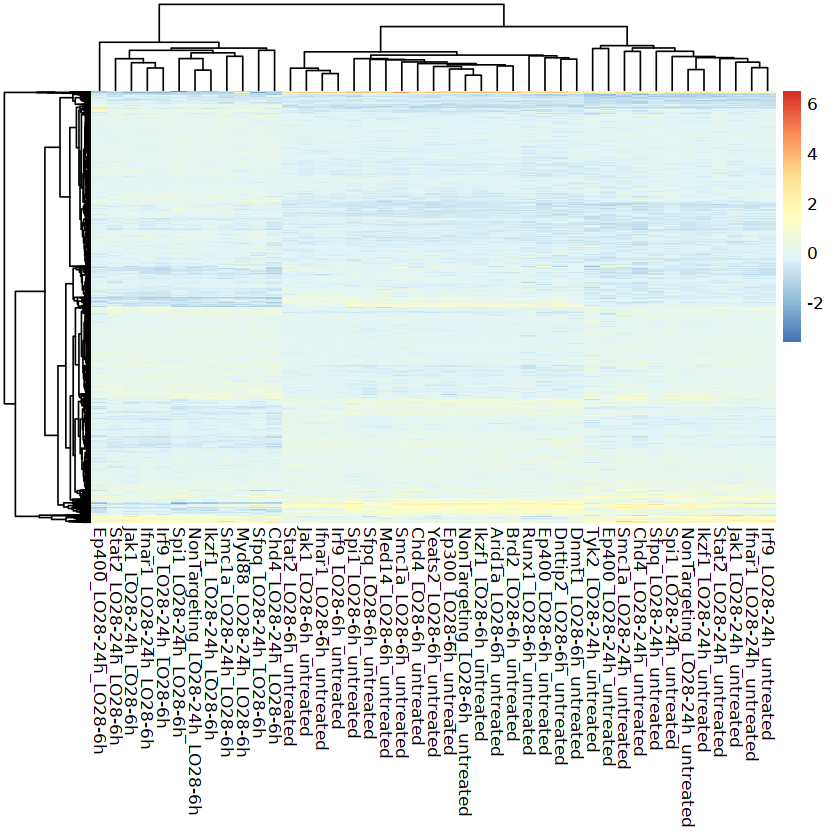

In [22]:
KO_genes <- vector()

for (KO_gene in unique(KO150$KO_call)){
#     print(KO_gene)
    
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            if ((sum(KO150$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO150$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)
            KO_genes <- append(KO_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign])
        }
    }
}

KO_genes <- unique(KO_genes)
length(KO_genes)

# make dataframe consisting of avg_log2FC of the identified DEGs
DEG_LFC_df = data.frame(matrix(ncol=0,nrow=length(KO_genes), dimnames=list(KO_genes, c())))

for (KO_gene in unique(KO150$KO_call)){
#     print(KO_gene)
    
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            if ((sum(KO150$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO150$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)
            DEG_LFC_df[KO_genes,paste0(KO_gene,'_',cond2,'_',cond1)] <- tmp_dea_genes[KO_genes,'avg_log2FC']
        }
    }
}

head(DEG_LFC_df)
dim(DEG_LFC_df)

print(sum(is.na(DEG_LFC_df))/(dim(DEG_LFC_df)[1]*dim(DEG_LFC_df)[2])*100)

#save dataframe
write.csv(DEG_LFC_df, file=file.path(results_path,paste0('KO150_DEA_KO_RNA_LFC.csv')))
    
# plot heatmap of LFC

# impute NA with 0 -> actually just below 0.1 -> VALID???
DEG_LFC_df[is.na(DEG_LFC_df)] <- 0

width <- 40
height <- 40

tmp_plot <- as.ggplot(pheatmap(DEG_LFC_df, show_rownames=FALSE))

# save plot
ggsave(
      paste0("KO150_",'clustermap',"_DEA_KO_RNA_LFC.png"),
      plot = tmp_plot,
      device = 'png',
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
        width = width,
        height = height,
      limitsize = FALSE,
    )

## dotplots of top DEGs per KO
https://satijalab.org/seurat/reference/dotplot

In [55]:
Idents(object = KO150) <- "KO_call"
levels(KO150)

[1] "Smc1a"        "Ifnar1"       "Sfpq"         "Tyk2"         "NonTargeting"
 [6] "Irf9"         "Spi1"         "Ep400"        "Ep300"        "Arid1a"      
[11] "Ikzf1"        "Dnttip2"      "Stat2"        "Chd4"         "Yeats2"      
[16] "Brd2"         "Jak1"         "Dnmt1"        "Med14"        "Sf3b1"       
[21] "Chd8"         "Runx1"        "Smarca4"      "Yeats4"       "Myd88"       
[26] "Stat1"        "Med8"         "Irf3"         "Ddx21"

In [56]:
# load DEA results per KO gene, filter for sign. genes (adj.p-value<stat_sign), take union of top_n, make dotplot
top_n <- 10
stat_sign <- 0.05
plot_dims <- 10

for (KO_gene in unique(KO150$KO_call)){
#     print(KO_gene)
    KO_genes <- vector()
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            if ((sum(KO150$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO150$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
          
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)
            KO_genes <- append(KO_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign][1:top_n])
        }
    }
    
    if (length(unique(KO_genes))==0){
        next
    }
    if (is.na(unique(KO_genes))){
        next
    }
    
    DotPlot(KO150, idents=c(KO_gene), group.by="condition", features = unique(KO_genes))+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    
    ggsave(
      paste0("KO150_",'dotplot',"_DEA_RNA_",KO_gene,"_top",top_n,"union.svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        height = 5,#plot_dims*length(unique(KO_genes))/length(unique(KO150$condition)),
        width = plot_dims
    )
}

Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in Fetch

## Volcano plots for DEA results per KO

In [57]:
DefaultAssay(KO150)

[1] "SCT"

In [58]:
for (KO_gene in unique(KO150$KO_call)){
#     print(KO_gene)
    KO_genes <- vector()
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            
            if ((sum(KO150$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO150$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
        
            RNA <- read.csv(file=file.path(results_path,paste0('KO150_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)

            AB <- read.csv(file=file.path(results_path,paste0('KO150_DEA_AB_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)

            res <- rbind(RNA, AB)

            keyvals.shape <- ifelse(rownames(res)%in%rownames(AB), 17, 20)# before 17,1
            names(keyvals.shape)[keyvals.shape == 17]<-"AB"
            names(keyvals.shape)[keyvals.shape == 20]<-"RNA"

            EnhancedVolcano(
                res,
                lab = rownames(res),
                x = 'avg_log2FC',
                y = 'p_val_adj',
                title = KO_gene,
                subtitle = paste0(cond2,' VS ',cond1),
                xlab=expression('average log'[2]*' fold change'),
                ylab=expression('-log'[10]*' adjusted p-value'),
                legendLabels=c('NS','avg.log2FC','adj.p-value', 'both'),
                pCutoff = 0.05,
                FCcutoff = 0.5,
                pointSize = 1.0,
                labSize = 3.0,
                colAlpha = 0.5,
                shapeCustom = keyvals.shape,
                legendPosition = 'right', #top, right, left, none
                caption = bquote("cutoffs avg." ~log[2]~ "FC 0.5; adj.p-value 0.05"),
            )

            ggsave(
              paste0("KO150_",'volcano',"_DEA_",KO_gene,'_',cond2,'_',cond1,".svg"),
              plot = last_plot(),
              device = "svg",
              path = file.path(results_path),
              scale = 1,
              dpi = 300,
              limitsize = FALSE,
            )
        }
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image